# Twitter Sentiment Analysis
Group members:



*   **Hanzala Sohrab** 
*   **Adarsh choudhary**


 

# Abstract
Social media has created a new way for individuals to express their thoughts and opinions. This medium is used by an estimated 2.95 billion people worldwide, generating a massive platform for ideas to be shared. Sentiment analysis, or opinion analysis, is the process of retrieving textual information and discerning which emotions are exhibited by the author. This type of analysis is used in many ways, including: determining consumers’ perception of a product, service, brand or marketing campaign; analyzing a company’s brand recognition on any social networking sites; examining citizen’s opinions on policy changes, government officials, campaigns, etc.

This project will perform sentiment analysis on real tweets harnessed from Twitter. The social networking service provides programmers with access to their data through its APIs (application programming interfaces). The primary aim is to provide a method for analyzing sentiment scores in noisy twitter streams. This is done by classifying individual tweets as either negative, neutral, or positive. If a large enough collection of tweets is analyzed, their collective sentiment score can then be used within a confidence range to state how the user pool feels towards the specific topic.

In our study, we were able to achieve an accuracy of 77.94% on individual tweet classifications, and a 95% confidence interval of ± 0.05 on aggregated sentiment score predictions. The best machine learning method was found to be Stochastic Gradient Descent. This model was then used on live tweets relating to various subject matters to extract real-time user sentiment.

# Background
Twitter is a good source of information for individuals' opinions. Twitter receives about 500 million tweets a day, where people share comments regarding a wide range of topics. Many consumers take to Twitter to give their opinion on current events, including real-time affairs. By performing sentiment analysis on these tweets, one can determine the polarity and inclination of a population towards specific topics, items, or entities. Retweeting is a largely used mechanism for information diffusion on Twitter. It has emerged as a simple yet powerful way of circulating information in the Twitter social realm.

On Twitter, users all over the world can express their opinion on any topic in a matter of seconds. By searching keywords or hashtags, anyone can scroll through a feed of content relating to any interest they like. The rise of social media has seen an uptick in polarizing content on the web, as it has become extraordinarily easy to share one's views.

One of the earliest and most common forms of sentiment analysis is to conduct a bag-of-words analysis. This is when individual words are used as features, and individual tweets are the observations. However, this creates a very large and sparse feature space. Bravo-Marques, Felipe, et al. (2015) combined this technique with a lower-dimension semantic vector to generate an opinion lexicon specifically oriented for Twitter posts. This is not always enough, though; many tweets include pictures, videos, GIFs, or other types of media that inherently add to the intended sentiment of the tweet. Wang, Min, et al. (2014) modified the typical bag of text words to include a bag of image words. By using a cross-media bag of words model, they were able to improve the accuracy of standard text-only models by 4%. Others have tried to implement much more complex models, such as convolutional neural networks (CNNs) or recurrent neural networks (RNNs).

A semi-automated method for creating sentiment dictionaries in several languages was suggested by Steinberger et al., (2012) and it yielded high-level sentiment dictionaries for two languages and automatic translation into a third language. Words discovered in the target language word list are typically utilized similar to the word sense in that of the two source languages.

Ji et al., (2010) proposed a sentiment mining and retrieval system which mines useful knowledge from product reviews. Furthermore, the sentiment orientation and comparison between positive and negative evaluation were presented visually in the system. Outcomes of experiments on a real-world dataset have shown the system is both feasible and effective.



## Aim
The main goal of this project is to build and train a model that can detect the sentiment of a tweet. For simplicity, this model limit its scope to label all tweets into one of these three categories:

negative
neutral
positive
Though there are many more specific sentiments that would need to be learned in order to obtain a clearer picture of a tweet's intentions, we will limit our model to learning these three classifications. However, a perfect model is nearly impossible to create. The reason is because sentiment is highly subjective. Roughly 20% of tweets would cause a debate amongst humans as to which category they fall into. To illustrate this, consider the following two tweets:

I love the world!

I hate the world.

These two tweets clearly fall into the positive and negative, respectively, sentiment categories. However, consider this tweet:

I am indifferent about the world.

This tweet lies somewhere in between the previous two. Yet, rather than labeling it as "neutral", one could argue that this in fact elicits a negative sentiment, as it is sad for someone to feel indifferent about the world. In any case, this classification is much less trivial to assign. Another non-trivial tweet is:

The S&P 500 was down 300 points on Thursday.

This would come as bad news for investors, but happy news for short-sellers. But broadly, this tweet doesn't seem to have any emotion, but rather only delivers a fact. Lastly, consider one more tweet:

I love candy, but it has too much sugar in it.

This person begins by saying something positive, but then ends it negatively. Overall, it is unclear whether this is a net-positive or net-negative tweet. It is also not as bland as the third example tweet; this sentence exhibits both positive and negative sentiments in one. The point of these examples is to show that sentiment analysis is not an exact science, and that this problem has an upper-bound. Even if a model had a 100% accuracy, humans would disagree with it about 20% of the time. Furthermore, not all sentiments are as easy to distinguish. A "neutral" label is much more subjective and poorly-defined than a "positive" or "negative" label.

# Problem Statement
We aim to create a machine learning model that is able to accurately classify the sentiment of a tweet. "Accuracy" for this model will be defined not only by its ability to correctly classify individual tweets, but also its ability to correctly classify large quantities of tweets to create an aggregated sentiment score.

Though the accuracy of the model on individual tweets will be limited by the subjective nature of this application, we believe it is reasonable to achieve very accurate aggregate scores. Once a model has been created, trained, and validated, we intend to use it on real-time and historical tweets to collect aggregated sentiment scores for varying topics. These can be used to compare real-time responses and attitudes towards different subjects. 

# Import packages

In [1]:
# Import basic packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import other relevant packages
import tweepy
import re
import io as _io
import math
import string
import pickle
from urllib.request import urlopen
from string import punctuation
from joblib import dump, load
from skimage import io
from wordcloud import WordCloud, STOPWORDS

# Import and download NLP functions
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

# Import sklearn functions
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

# Import estimators
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier, Perceptron, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier

# Import streamlined methodology methods
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator
from sklearn.model_selection import GridSearchCV
import joblib

[nltk_data] Downloading package punkt to /home/hanzala/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/hanzala/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/hanzala/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/hanzala/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
# from google.colab import files
# uploaded = files.upload()

In [3]:
inputs = ['I love the world',
          'I hate the world',
          'I am indifferent about the world']

w = ['I', 'love', 'hate', 'am', 'indifferent', 'about', 'the', 'world']
m = [[1, 1, 0, 0, 0, 0, 1, 1],
     [1, 0, 1, 0, 0, 0, 1, 1],
     [1, 0, 0, 1, 1, 1, 1, 1]]
pd.DataFrame(m, columns=w)

tf = TfidfTransformer()
m = tf.fit_transform(m).todense()
pd.DataFrame(m, columns=w)

,I,love,hate,am,indifferent,about,the,world
0,0.412859,0.69903,0.00000,0.00000,0.00000,0.00000,0.412859,0.412859
1,0.412859,0.00000,0.69903,0.00000,0.00000,0.00000,0.412859,0.412859
2,0.293607,0.00000,0.00000,0.49712,0.49712,0.49712,0.293607,0.293607


# Utility functions

In [4]:
def print_balance(df, col='senti'):
    if type(df) == pd.DataFrame:
        counts = df[col].value_counts(normalize=True)
    else:
        labels, counts = np.unique(y_test, return_counts=True)
        counts = dict(zip(labels, counts / len(y_test)))

    print(f'This dataset contains {int(counts[0]*len(df))} negative tweets ({counts[0]})')
    print(f'This dataset contains {int(counts[2]*len(df))} neutral tweets ({counts[2]})')
    print(f'This dataset contains {int(counts[4]*len(df))} positive tweets ({counts[4]})')
    return counts

def balance(df, col='senti', weights=(1, 1, 1)):
    # Get the number of observations with each classification
    counts = df[col].value_counts(normalize=True)

    # Get the smallest number of observations for a sentiment label
    minNum = int(counts.min() * len(df))

    # Split the observations by sentiment and keep the same number of observations for each
    df_neg = df[df.senti == 0].iloc[:int(minNum*weights[0]), :]
    df_neu = df[df.senti == 2].iloc[:int(minNum*weights[1]), :]
    df_pos = df[df.senti == 4].iloc[:int(minNum*weights[2]), :]

    # Combine observations back into one dataframe 
    df_bal = pd.concat([df_neg, df_neu, df_pos])
    return df_bal

def clean_sentiment(s):
    '''
    This function cleans the sentiment label for tweets in the Sanders Analytics dataset.
    
    Inputs: string (sentiment label : {'negative', 'neutral', 'positive'})
    Outputs: integer (sentiment label : {0, 2, 4})
    '''
    if s == 'positive':
        return 4
    elif s == 'negative':
        return 0
    else:
        return 2

def preprocessTweets(text):
    text = str(text)
    text = text.translate(str.maketrans('', '', string.punctuation))    # Remove punctuation
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', text)     # Remove URLs
    text = re.sub('@[^\s]+', 'AT_USER', text)                           # Remove usernames
    return text


class ClfSwitcher(BaseEstimator):

    def __init__(self, estimator=SVC(probability=True)):
        """
        A Custom BaseEstimator that can switch between classifiers.
        :param estimator: sklearn object - The classifier
        """ 

        self.estimator = estimator

    def fit(self, X, y=None, **kwargs):
        self.estimator.fit(X, y)
        return self

    def predict(self, X, y=None):
        return self.estimator.predict(X)

    def predict_proba(self, X):
        return self.estimator.predict_proba(X)

    def score(self, X, y):
        return self.estimator.score(X, y)

# Get Training Data

For our training data, we will use two datasets.

The first dataset we will use comes from GitHub user TharinduMunasinge. This dataset contains 997 tweets that have a pre-labeled sentiment:

0 = negative
2 = neutral
4 = positive

In [5]:
# data1 = pd.read_csv(_io.BytesIO(uploaded['FinalizedFull.csv'])).rename(columns={'tweet':'text'})
data1 = pd.read_csv('./data/FinalizedFull.csv').rename(columns={'tweet':'text'})
data1.head()

,text,senti
0,@united UA5396 can wait for me. I'm on the gro...,0
1,I hate Time Warner! Soooo wish I had Vios. Can...,0
2,"@united Oh, we are sure it's not planned, but ...",0
3,Tom Shanahan's latest column on SDSU and its N...,2
4,Found the self driving car!! /IWo3QSvdu2,2


In [6]:
# Check the balance of the dataset
counts1 = print_balance(data1)

This dataset contains 377 negative tweets (0.3781344032096289)
This dataset contains 239 neutral tweets (0.23971915747241726)
This dataset contains 381 positive tweets (0.38214643931795383)


As we can see, this dataset is not balanced. More tweets are labeled positive or negative than neutral. While this may be representative of all tweets, we may need to consider this so as to not bias our model. However, this dataset contains relatively few observations, so we will combine it with another dataset of labeled tweets as well.

The second dataset we will use in our training set comes from the twitter sentiment corpus created by Sanders Analytics. This dataset consists of 3424 relevant hand-classified tweets. Irrelevant observations in this dataset include Spanish content. For this project, we will restrict our model to only classify English tweets.

In [7]:
# Read in the dataset
# data2 = pd.read_csv(_io.BytesIO(uploaded['full-corpus.csv']))[['Sentiment', 'TweetText']].rename(columns={'Sentiment':'senti', 'TweetText':'text'})
data2 = pd.read_csv('./data/full-corpus.csv')[['Sentiment', 'TweetText']].rename(columns={'Sentiment':'senti', 'TweetText':'text'})

# Drop all spanish observations
data2 = data2[data2.senti != 'irrelevant']

# Clean the sentiment labels
data2['senti'] = data2['senti'].apply(clean_sentiment)

data2.head()

,senti,text
0,4,Now all @Apple has to do is get swype on the i...
1,4,@Apple will be adding more carrier support to ...
2,4,Hilarious @youtube video - guy does a duet wit...
3,4,@RIM you made it too easy for me to switch to ...
4,4,I just realized that the reason I got into twi...


In [8]:
# Check the balance of the dataset
counts2 = print_balance(data2)

This dataset contains 572 negative tweets (0.16705607476635514)
This dataset contains 2333 neutral tweets (0.6813668224299065)
This dataset contains 519 positive tweets (0.15157710280373832)


Unlike the first dataset, this corpus contains significantly more neutral tweets than it does positive/negative tweets. In any case, we will combine these two datasets to create a larger training set to work with.

In [9]:
# Concatenate both training sets and preprocess tweets
train = pd.concat([data1, data2])
train['text'] = train['text'].apply(preprocessTweets)

# Check the balance of the dataset
train_counts = print_balance(train)

This dataset contains 949 negative tweets (0.21465731734901605)
This dataset contains 2572 neutral tweets (0.5817688305813165)
This dataset contains 900 positive tweets (0.2035738520696675)


In our comined training set, the number of neutral tweets is much larger than either of the other sentiments. Because neutral tweets are much harder to learn, it makes sense that we have a higher representation of these examples when training our model. For example, this tweet

> That is awesome! I love this!

is very easy and trivial to classify as positive. Likewise, this tweet

> I hate people like wtf

can be classified as negative without much difficult as well. However, this tweet



> Mr Lee, it is because I vape that I now can exercise more. Here is my take on forgetting bad memories, I have done it all my life ...its called a new day.



is much harder to decipher. It appears the person is in an argument and trying to keep his temper while also pushing an uplifting tone. Is it positive? Not really. Is it negative? Also no. Is it neutral? I guess? It is much more difficult to discern neutral tweets. With this in mind, we will keep our training set unbalanced in favor of having more neutral tweets to train our model.

In [10]:
# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(train.text.values, train.senti.values, random_state=637)

In [11]:
# Split the test set into two equal parts
X_test_bal, X_test_full, y_test_bal, y_test_full = train_test_split(X_test, y_test, test_size=0.5, random_state=637)

# See composition of unbalanced test set
print('\033[1mComposition of unbalanced test set:\033[0m')
print_balance(y_test_full)

# Create the balanced dataframe
test_bal = pd.DataFrame({'text':X_test_bal, 'senti':y_test_bal})
test_bal = balance(test_bal)
print('\n\033[1mComposition of balanced test set:\033[0m')
print_balance(test_bal)

X_test_bal = test_bal.text.values
y_test_bal = test_bal.senti.values

Composition of unbalanced test set:
This dataset contains 111 negative tweets (0.20162748643761302)
This dataset contains 327 neutral tweets (0.5913200723327305)
This dataset contains 114 positive tweets (0.2070524412296564)

Composition of balanced test set:
This dataset contains 114 negative tweets (0.3333333333333333)
This dataset contains 114 neutral tweets (0.3333333333333333)
This dataset contains 114 positive tweets (0.3333333333333333)


# Overall Methodology

First, we will use CountVectorizer to create a dictionary where the keys are every word in the training set and the values are the frequencies of each word.

bow = CountVectorizer( lowercase=True,
                      strip_accents='ascii',
                      stop_words='english')

bow.fit(X)

Next, we will convert the tweet text data (which is a 1D array) to an  matrix, where n is the number of tweets in the training data and w is the number of words in the vocabulary dictionary. Each value in the matrix represents the number of times a given word appears in a given tweet. This will result in a very sparse dataset.

bow_matrix = bow.transform(X)<br>
After this, we will use TfidfTransformer to calculate the term-frequency times inverse document-frequency (tf-idf) value for each word in the training set.

term-frequency is the number of times the word appears in a tweet
inverse document-frequency is the number of texts that contain the word
Hence, a word's tf-idf score increases proportionally to the number of times it appears in the text, and is offset by the total number of tweets that contain the word. This is used to determine the importance of a word in a given tweet. The more times the word appears in the tweet, the more important it must be to the sentiment of the tweet. However, if many tweets contain this word, it must not be as important in differentiating between sentiments.

The fit() method will learn the idf vector, which is the total number of tweets that contain each word. The transform() method will compute the tf vector and calculate the tf-idf matrix.

tfidf_transformer = TfidfTransformer()<br> 
tfdif.fit(bow_matrix)<br>
messages_tfidf = tfidf_transformer.transform(bow_matrix)

The following figure gives a visual representation of how these modules manipulate the data to prepare it for a classical estimator.
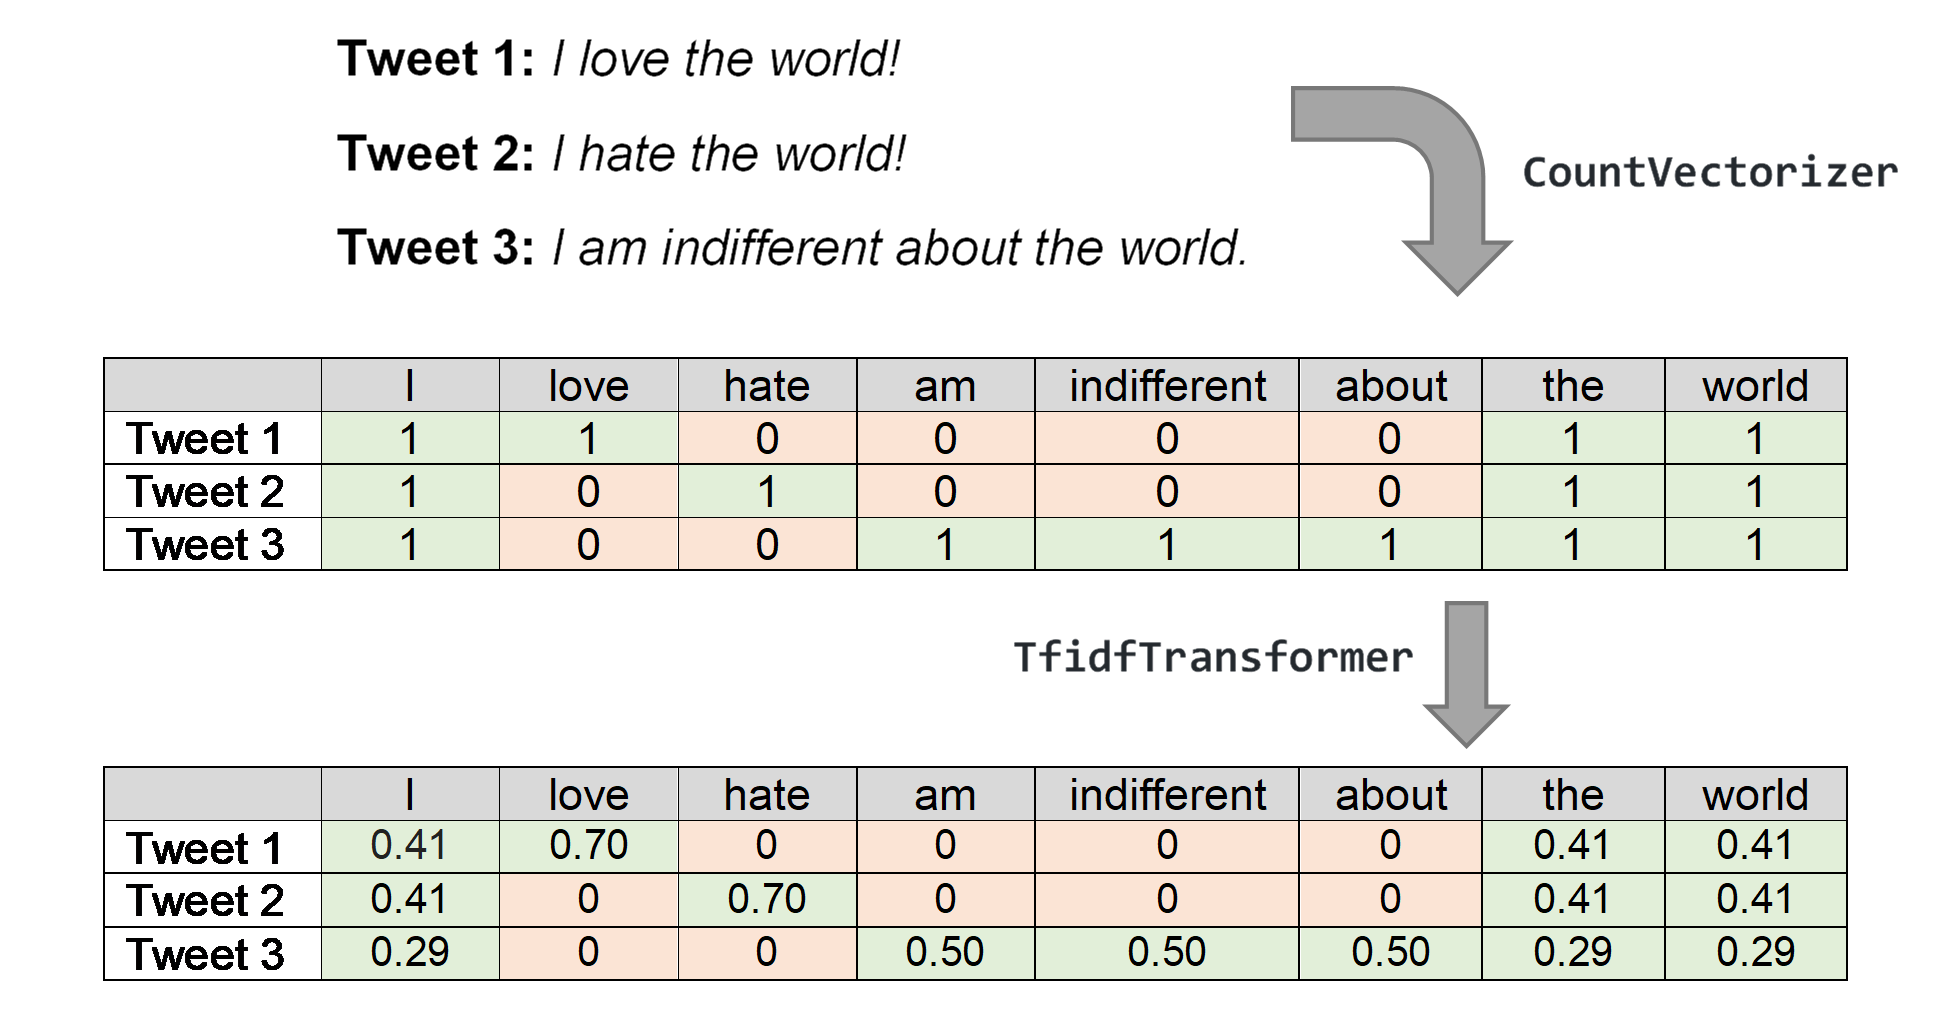 

**Figure 1**: The above figure shows how CountVectorizer and TfidfTransformer convert a collection of words into a bag-of-words tf-idf matrix.

</br> Finally, we will use MultinomialNB to train the tf-idf vectors with a Naive-Bayes classifier. This will be the final model that is used to classify tweet sentiment.

model = MultinomialNB().fit(messages_tfidf)

## Streamlined Methodology
The TfidfVectorizer is a module which is equivalent to CountVectorizer followed by TfidfTransformer. This will convert raw text into a tf-idf matrix. Rather than have two separate objects, we can combine them into one.

This entire process can be further streamlined by using the Pipeline object. This object will conduct a series of fits and transforms. On different estimators. By setting up our Pipeline to first fit a TfidfVectorizer to our training data and then fit a MultinomialNB to the result, we have fully replicated our process in only one object. This will become extremely helpful when tuning our model.




  pipeline = Pipeline([

        ('tfidf', TfidfVectorizer(lowercase=True,
                                 strip_accents='ascii',
                                stop_words='english')),
                        ('classifier', MultinomialNB()),
        ])
The first element of each tuple passed into the Pipeline is the name of the estimator. The second element of each tuple is the estimator itself, instantiated with any non-changing arguments.

## Cross Validation
The benefit of using the Pipeline approach is that it allows us to apply cross validation on both of our estimators at once. Using GridSearchCV, we are able to create models that cycle through a given set of hyperparameters.

The parameters dictionary contains the set of hyperparameters to loop through. In our case, the hyperparameters of our model are the arguments that are passed into each estimator. The parameters dictionary is created using the following format:

parameters = {estimatorName__argumentName : [list_of_hyperparameters]}

> parameters = {  
              
              'tfidf__ngram_range': [(1, 1), (1, 2)],
              'tfidf__norm' : ['l1', 'l2'],
              'classifier__fit_prior' : [True, False],
              'classifier__alpha' : np.arange(0.1, 1.5, 16)
               }


             
We can then find and compute the best hyperparameters for our model by cycling through these arguments and using 10-fold cross validation. Using the optimal hyperparameters, we can then train our final model on the full training set.

grid = GridSearchCV(pipeline, cv=10, param_grid=parameters, verbose=1)

grid.fit(X, y)

## Testing Multiple Classifiers
One last improvement we can make is to define a CLFSwitcher function that will allow us to use different classifier methods in our Pipeline process. This object needs to extend the fit(), predict(), predict_proba(), and score() methods of the classifier to be used. To implement this change, we need to make slight adjustments to our Pipeline process and parameters list.

pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(lowercase=True, 
                                strip_accents='ascii',
                                stop_words='english')),
        ('clf', CLFSwitcher()),           # Replace MultinomialNB to CLFSwitcher           
        ])
This is very helpful, because it allows us to not only pass in different estimators as a hyperparameter, but also because each estimator has unique hyperparameters of its own. The hyperparameters of a Naive Bayes classifier are different from those of a Support Vector classifier. With this wrapper class, we can pass in multiple estimators, as well as their unique parameters, to GridSearchCV when tuning our model. In our parameters list, we create multiple dictionaries -- one for each classifier. For two classifiers, the parameters list would look like

 
        parameters = [    
            {
              'clf__estimator': [MultinomialNB()],
             'tfidf__ngram_range': [(1, 1), (1, 2)],
             'tfidf__norm' : ['l1', 'l2'],
             'clf__estimator__fit_prior' : [True, False],
             'clf__estimator__alpha' : np.arange(0.1, 1.5, 16)
            },
            {'clf__estimator': [SGDClassifier(random_state=637, n_jobs=-1)],
             'tfidf__ngram_range': [(1, 1), (1, 2)],
             'tfidf__norm' : ['l1', 'l2'],
             'clf__estimator__loss': ['hinge', 'log', 'modified_huber'],
             'clf__estimator__penalty': ['l1', 'l2', 'elasticnet']
            },
For this project, we will be cross validating with the following classifiers:


*   Support Vector Machines
*   Naive Bayes
*   K-Nearest Neighbor
*   Random Forests
*   Logistic Regression




By cross validating among each of these classifiers (as well as cross validating among the hyperparameters of each estimator) we will be able to achieve the best model possible for our training data.

# Model Code
This is the class for our tiwtter sentiment analysis model that implements the above methodology in a clean and user-friendly manner.

In [12]:
class TwitterSentimentModel():

    def __init__(self):
        pass

    def fit(self, X, y, classifier='all', cv=10, verbose=False):

        X = [preprocessTweets(t) for t in X]

        # Create the Pipeline object
        pipeline = Pipeline([
            ('tfidf', TfidfVectorizer(lowercase=True, 
                                strip_accents='ascii',
                                stop_words='english')),
            ('clf', ClfSwitcher())
        ])

        # this is where we define the values for GridSearchCV to iterate over
        parameters = [
            { # For SVM, the best accuracy was 70.67% on the test data (71.36% on training data) -- runs in about 60 sec
             'clf__estimator': [SVC(random_state=637, probability=True)],
             'tfidf__ngram_range': [(1, 1), (1, 2)],
             'tfidf__norm' : ['l1', 'l2'],
             'clf__estimator__kernel' : ['rbf', 'linear', 'sigmoid'],
            },
            { # For Naive Bayes, the best accuracy was 68.30% on the test data (70.12% on training data) -- runs in about 5.1 sec
             'clf__estimator': [MultinomialNB()],
             'tfidf__ngram_range': [(1, 1), (1, 2)],
             'tfidf__norm' : ['l1', 'l2'],
             'clf__estimator__fit_prior' : [True, False],
             'clf__estimator__alpha' : np.arange(0.1, 1.5, 16)
            },
            { # For KNN, the best accuracy was 62.96% on the test data (64.25% on training data) -- runs in about 35.3 sec
             'clf__estimator': [KNeighborsClassifier()],
             'tfidf__ngram_range': [(1, 1), (1, 2)],
             'tfidf__norm' : ['l1', 'l2'],
             'clf__estimator__leaf_size': [10, 30, 50],
             'clf__estimator__n_neighbors' : [1, 5, 10, 20]
            },
             { # For Random Forests, the best accuracy was 68.30% on the test data (69.13% on training data) -- runs in about 1.7 min (102 sec)
             'clf__estimator': [RandomForestClassifier(random_state=637, n_jobs=-1)],
             'tfidf__ngram_range': [(1, 1)],
             'tfidf__norm' : ['l1', 'l2'],
             'clf__estimator__criterion' : ['gini', 'entropy'],
             'clf__estimator__min_samples_leaf' : [1, 5],
             'clf__estimator__max_depth' : [5, 25, None]
            },
            { # For Logistic Regression, the best accuracy was 69.48% on the test data (70.12% on training data) -- runs in about 14.1 sec
             'clf__estimator': [LogisticRegression(random_state=637, n_jobs=-1)],
             'tfidf__ngram_range': [(1, 1), (1, 2)],
             'tfidf__norm' : ['l1', 'l2'],
             'clf__estimator__C' : np.arange(0.5, 1.5, 11)
            }]
        
        param_dict = {
            'SVM' : 0, 
            'Naive Bayes' : 1,
            'KNN' : 3,
            'Random Forest' : 4,
            'Logistic Regression' : 6
        }

        if classifier != 'all':
            parameters = parameters[param_dict[classifier]]
        else:
            pass

        # do 10-fold cross validation for each of the combinations of the above params
        self.grid = GridSearchCV(pipeline, cv=cv, param_grid=parameters, n_jobs=-1, verbose=1)
        self.grid.fit(X, y)
         # summarize results
        print("\nBest Model: {0:.2%} using {1}".format(self.grid.best_score_, self.grid.best_params_))
        print('\n')
        self.compile_results(X, y)


    def compile_results(self, X, y):
        self.means = self.grid.cv_results_['mean_test_score']
        self.stds = self.grid.cv_results_['std_test_score']
        self.params = self.grid.cv_results_['params']

        # Define the estimator tested
        estimators = {
            SVC : 'SVC',
            MultinomialNB : 'Naive Bayes',
            KNeighborsClassifier : 'KNN',
            RandomForestClassifier : 'Random Forest',
            LogisticRegression : 'Logistic Regression'
        }

        # Organize the estimator performance into a data frame
        data = {
            'Estimator':[estimators[type(e['clf__estimator'])] for e in self.params],
            'score': self.means,
            'ngram_range': [e['tfidf__ngram_range'] for e in self.params],
            'tfidf__norm' : [e['tfidf__norm'] for e in self.params],
            'computing_time' : self.grid.cv_results_['mean_fit_time'],
            'estimator_obj' : [e['clf__estimator'] for e in self.params]
        }

        self.all_results = pd.DataFrame(data=data)

        # Get the best performing model for each estimator
        idx = self.all_results.groupby(['Estimator'])['score'].transform(max) == self.all_results['score']
        self.results = self.all_results[idx]
        idx = self.results.groupby(['Estimator'])['computing_time'].transform(max) == self.results['computing_time']
        self.results = self.results[idx].set_index('Estimator')


    def set_uncertainty(self, X, y):
        # Find the standard error on aggregate sentiment scores
        print('Calculating uncertainty for aggregate sentiment scores...')
        self.agg_errs, self.agg_true_means, self.agg_pred_means = self.agg_sent_score(X, y,
                                                                                      n_bootstraps=1000,
                                                                                      bootstrap_size=1000,
                                                                                      verbose=True)
        self.agg_me = self.agg_errs.mean()     # Mean average error in aggregated sentiment scores
        self.agg_unc = model.agg_errs.std()*2  # Uncertainty in aggregated sentiment scores (95% confidence)
        print('Done! Aggregate sentiment uncertainty = {0:.4f}'.format(self.agg_unc))


    def print_all_results(self):
        for mean, stdev, param in zip(self.means, self.stds, self.params):
            param = param.copy()
            del param['clf__estimator']
            print("Mean: %f Stdev:(%f) with: %r" % (mean, stdev, param))


    def score(self, X, y, verbose=False):
        return self.grid.score(X, y)


    def predict(self, X, vebose=False):
        return self.grid.predict(X)


    def predict_proba(self, X):
        return self.grid.predict_proba(X)


    def predict_agg(self, X, verbose=False):
        agg_sent = ((self.grid.predict(X) - 2) / 2).mean()
        agg_unc = self.agg_unc * np.sqrt(1000 / len(X))
        if verbose: print('(scale from -1 to 1) Aggregated sentiment score: {0:.2f} \u00B1 {1:.2f}\n'.format(agg_sent, agg_unc))
        return agg_sent, self.agg_unc


    def classification_report(self, X, y):
        y_preds = self.predict(X)
        print(classification_report(y, y_preds))


    def confusion_matrix(self, X, y):
        y_preds = self.predict(X)
        print('\nconfusion matrix: \n',confusion_matrix(y,y_preds), '\n')


    def estimator_performance(self, metric='score', ylim=(0.6, 0.75)):
        # Plot the performance
        fig, ax = plt.subplots(figsize=(7, 5))
        self.results.sort_values(by=metric, ascending=False).plot.bar(y=metric, ax=ax, rot=45, legend=False)
        ax.set_ylim(ylim)
        ax.set_title('Model Performance for Each Estimator', fontsize='x-large')
        ax.set_xlabel('Estimator Type', fontsize='x-large')

        if metric == 'score':
            ax.set_ylabel('Max model accuracy', fontsize='x-large')
        elif metric == 'computing_time':
            ax.set_ylabel('Mean time to fit model (s)', fontsize='x-large')
        else:
            pass
        fig.show()
        return fig

    def sentiment_performance(self, X, y, ylim=0.5):
        # Get results
        report = classification_report(y, self.predict(X), output_dict=True)
        neg_results = list(report['0'].values())[:3]
        neu_results = list(report['2'].values())[:3]
        pos_results = list(report['4'].values())[:3]

        # Set position of bar on X axis
        barWidth = 0.25
        x1 = np.arange(len(neg_results))
        x2 = [x + barWidth for x in x1]
        x3 = [x + barWidth for x in x2]

        # Plot the performance
        fig, ax = plt.subplots(figsize=(7, 5))

        # Make the plot
        ax.bar(x1, neg_results, color='indianred', width=barWidth, edgecolor='white', label='Negative')
        ax.bar(x2, neu_results, color='sandybrown', width=barWidth, edgecolor='white', label='Neutral')
        ax.bar(x3, pos_results, color='mediumseagreen', width=barWidth, edgecolor='white', label='Postiive')
        ax.set_xticks(x2)
        ax.set_xticklabels(('Precision', 'Recall', 'F1 Score'), fontsize='x-large')
        ax.set_ylim(0, 1)
        ax.set_title('Best Estimator Performance on Different Sentiments', fontsize='x-large')

        ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        fig.show()
        return report


    def plot_roc(self, X_test, y_test):
        y_score = self.predict_proba(X_test)

        # Reshape y_test
        ytest = []
        for i in y_test:
            if i == 0:
                ytest.append([1, 0, 0])
            elif i == 2:
                ytest.append([0, 1, 0])
            else:
                ytest.append([0, 0, 1])
        y_test = np.array(ytest)
   
     # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(3):
            fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        fig, ax = plt.subplots(figsize=(7, 7))
        for i, title in enumerate(['Negative', 'Neutral', 'Positive']):
            ax.plot(fpr[i], tpr[i], label=title + ' tweets (AUC = %0.2f)' % roc_auc[i])
        ax.plot([0, 1], [0, 1], color='black', linestyle='--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.0])
        ax.set_xlabel('False Negative Rate', fontsize='x-large')
        ax.set_ylabel('True Positive Rate', fontsize='x-large')
        ax.set_title('ROC Curve of Each Sentiment', fontsize='xx-large')
        ax.legend(loc="lower right")
        fig.show()
        return fig


    def agg_sent_score(self, X, y, n_bootstraps=1000, bootstrap_size=1000, verbose=False):
        np.random.seed(637)
        true_means, pred_means, errs = np.ones(n_bootstraps), np.ones(n_bootstraps), np.ones(n_bootstraps)
        for i in range(n_bootstraps):
            if verbose:
                if not (i+1)%(n_bootstraps//5): print('{0:.0f}% done'.format((i+1)/(n_bootstraps//100)))
            ind = np.random.randint(0, len(X), int(bootstrap_size))
            X_boot = X[ind]
            y_boot = y[ind]
            y_pred = self.grid.predict(X_boot)

            # Standardize predictions to a -1 to 1 scale
            y_boot = (y_boot - 2) / 2
            y_pred = (y_pred - 2) / 2
            

            true_means.put(i, y_pred.mean())
            pred_means.put(i, y_boot.mean())
            errs.put(i, y_boot.mean() - y_pred.mean())

        self.mean_agg_error = errs.mean()
        return errs, true_means, pred_means


    def agg_sent_hist(self, X, y, n_bootstraps=1000, bootstrap_size=1000, verbose=False):
        errs, true_means, pred_means = self.agg_sent_score(X, y, n_bootstraps, bootstrap_size, verbose)
        fig, ax = plt.subplots(figsize=(7, 7))
        ax.hist(errs)
        plt.axvline(errs.mean(), color='k', linestyle='dashed')
        ax.set_xlabel('Aggregated Sentiment Error', fontsize='xx-large')
        ax.set_title('Sentiment Score Prediction Error', fontsize='xx-large')
        fig.show()
        return fig


    def agg_sent_plot(self, X, y, n_bootstraps=1000, bootstrap_size=1000, verbose=False):
        errs, true_means, pred_means = self.agg_sent_score(X, y, n_bootstraps, bootstrap_size, verbose)
        fig, ax = plt.subplots(figsize=(7, 7))
        ax.scatter(true_means, pred_means)
        ax.plot(true_means, true_means, color='red')
        ax.set_ylabel('Predicted Sentiment Score', fontsize='xx-large')
        ax.set_xlabel('Actual Sentiment Score', fontsize='xx-large')
        fig.show()
        return fig

    def word_cloud(self, tweets, labels=None, sentiment=None, showfig=True, mask=None, ngrams_range=(1, 2)):
        sent_dict = {'negative':0,
                    'neutral':2,
                    'positive':4}

        tweets = [preprocessTweets(tweet) for tweet in tweets]
        if labels is None:
            labels = self.predict(tweets)

        # Get desired tweets
        if sentiment:
            tweets = [tweets[i] for i in np.where(labels == sent_dict[sentiment])[0]]

        # Get vocabulary of tweets
        tfidf = TfidfVectorizer(lowercase=True, 
                                strip_accents='ascii',
                                stop_words='english',
                                ngram_range=ngrams_range)
        tfidf.fit(tweets)
        
        vocabulary = tfidf.vocabulary_
        weights = tfidf.idf_
        weight_dict = {v:w for v, w, in zip(vocabulary, weights)}

        # Create Word Cloud
        word_cloud = WordCloud(width=2000,
                                height=1000,
                                max_font_size=200, 
                                background_color="white",
                                max_words=100,
                                mask=mask,
                                contour_width=1,
                                stopwords=STOPWORDS.add('https'))
        word_cloud.generate_from_frequencies(weight_dict)

        # Plot the Word Cloud
        fig = plt.figure(figsize=(10,10))
        plt.imshow(word_cloud, interpolation="hermite")
        plt.axis("off")     
        if showfig: fig.show()
        return fig

# Create and test model on full training data

Let us now use our algorithm to train a model and test it

In [13]:
# if False:
model = TwitterSentimentModel()
# model.fit(X_train, y_train, classifier='SVC')
model.fit(X_train, y_train)
model.set_uncertainty(X_test, y_test)

with open("trained_model.pickle", "wb") as f:
    pickle.dump(model, f)

Fitting 10 folds for each of 96 candidates, totalling 960 fits

Best Model: 75.69% using {'clf__estimator': SVC(kernel='linear', probability=True, random_state=637), 'clf__estimator__kernel': 'linear', 'tfidf__ngram_range': (1, 2), 'tfidf__norm': 'l2'}


Calculating uncertainty for aggregate sentiment scores...
20% done
40% done
60% done
80% done
100% done
Done! Aggregate sentiment uncertainty = 0.0347


In [14]:
model_location = './trained_model.pickle'
model = load(model_location)

# Validate model performance

In [15]:
acc = model.score(X_test_full, y_test_full), model.score(X_test_bal, y_test_bal) 
print('accuracy on original test set: {0:.2%}'.format(acc[0])) 
print('accuracy on balanced test set: {0:.2%}'.format(acc[1])) 

accuracy on original test set: 78.30%
accuracy on balanced test set: 69.30%


/tmp/ipykernel_15378/1235964044.py:241: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


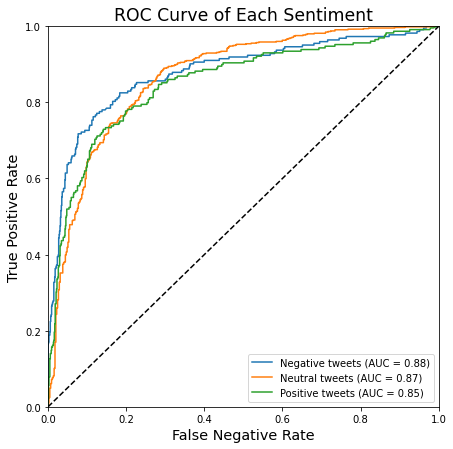

In [16]:
fig = model.plot_roc(X_test, y_test)
fig.savefig('roc.png')

/tmp/ipykernel_15378/1235964044.py:276: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Mean aggregate score error: 0.01892


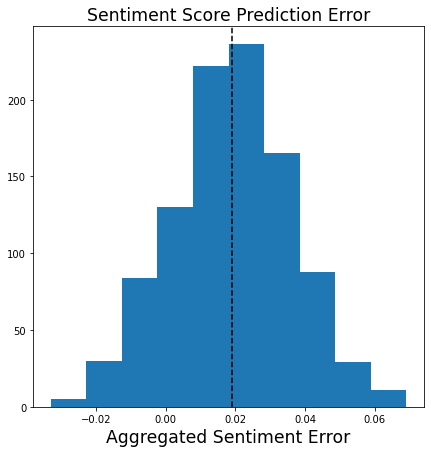

In [17]:
fig = model.agg_sent_hist(X_test, y_test)
print('Mean aggregate score error: {0:.5f}'.format(model.agg_me))
fig.savefig('agg_error_hist.png')

/tmp/ipykernel_15378/1235964044.py:287: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


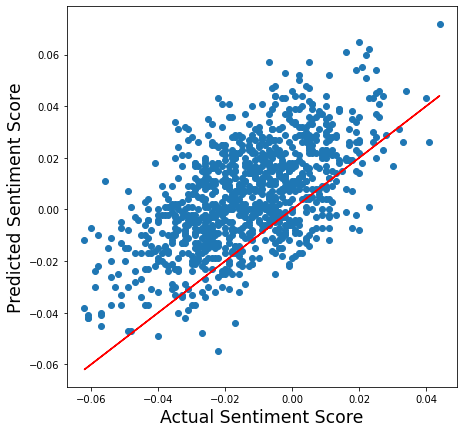

In [18]:
fig = model.agg_sent_plot(X_test, y_test)
fig.savefig('agg_error_scatter.png')

/tmp/ipykernel_15378/1235964044.py:201: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


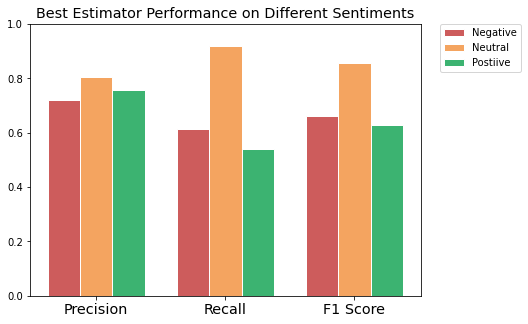

In [19]:
result_dict = model.sentiment_performance(X_test_full, y_test_full)

In [20]:
print('\033[1m\tClassification report on the Original Test Set\033[0m')
model.classification_report(X_test_full, y_test_full)

#print('\n\n\033[1m\tClassification report on the Balanced Test Set\033[0m')
#model.classification_report(X_test_bal, y_test_bal);

	Classification report on the Original Test Set
              precision    recall  f1-score   support

           0       0.72      0.62      0.66       104
           2       0.80      0.92      0.86       334
           4       0.76      0.54      0.63       115

    accuracy                           0.78       553
   macro avg       0.76      0.69      0.72       553
weighted avg       0.78      0.78      0.77       553



# Compare the different estimators' performance

/tmp/ipykernel_15378/1235964044.py:172: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


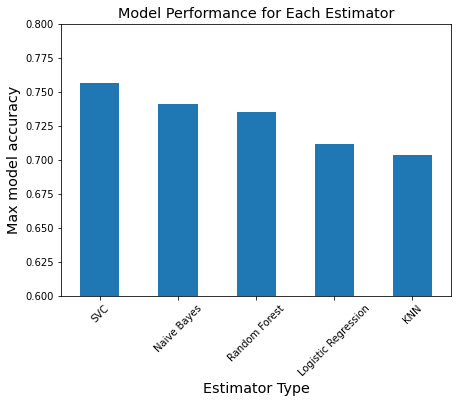

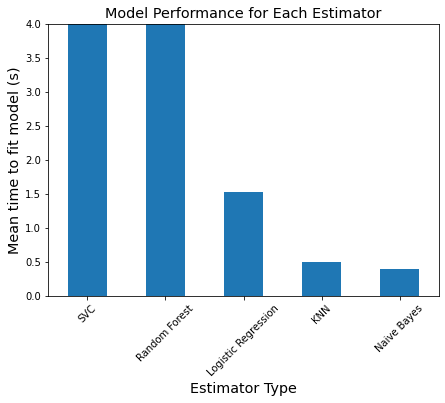

In [21]:
fig = model.estimator_performance('score', ylim=(0.6, 0.8))
fig.savefig('estimator_performance.png')

fig = model.estimator_performance('computing_time', ylim=(0, 4))
fig.savefig('estimator_time.png')

Using the model to predict sentiment

In [22]:
model.grid.predict_proba(['I love the world'])

array([[2.32032730e-07, 2.68749183e-07, 9.99999499e-01]])

In [23]:
model.grid.predict_proba(['I am indifferent about the world'])

array([[0.10967787, 0.78329277, 0.10702936]])